State:
    (int, int, int, int) -- tuple of (y_pos, x_pos, y_velocity, x_velocity).
    current state is returned by env.step as a result of a taken action
Actions:
    RacetrackEnv.ACTIONS_DICT = {
        0 : (1, -1),  # Acc Vert., Brake Horiz.
        1 : (1, 0),   # Acc Vert., Hold Horiz.
        2 : (1, 1),   # Acc Vert., Acc Horiz.
        3 : (0, -1),  # Hold Vert., Brake Horiz.
        4 : (0, 0),   # Hold Vert., Hold Horiz.
        5 : (0, 1),   # Hold Vert., Acc Horiz.
        6 : (-1, -1), # Brake Vert., Brake Horiz.
        7 : (-1, 0),  # Brake Vert., Hold Horiz.
        8 : (-1, 1)   # Brake Vert., Acc Horiz.
    }
Reward:
    -1 for every step except for the terminal when finish is reached
    -10 additional penalty if border is crossed
    +10 additional reward if finish is reached
################################################################################

Return of env.step():
    {(int, int, int, int)} -- The next state, a tuple of (y_pos, x_pos, y_velocity, x_velocity).
    {int} -- The reward earned by taking the given action in the current environment state.
    {bool} -- Whether the environment's next state is terminal or not.

TODO
1. Understand the logic of importance multipliers
2. Understand exactly why if beh. policy is not updated (episode is dropped if current step is not best action), episodes take longer
3. Try increasing rewards for beh policy if state is not visited for a long time (k*sqrt(tau), tau - time since visit)


In [1]:
from racetrack_env import RacetrackEnv
import gym
import random
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ON-POLICY MC

In [8]:
def find_max_val_action_for_state(state_action_values, state, eps = 0.6):
    res_d = {}
    visits = 0
    for k in state_action_values:
        if k[0] == state:
            res_d[k] = state_action_values[k]['value']
            visits+= state_action_values[k]['visits']
    
    if res_d:
        if (np.random.uniform() < 1-(1/visits)):
#         if (np.random.uniform() < eps):
            return max(res_d, key=res_d.get)[1]
        else:
            return random.choice(env.get_actions())
    else:
        return random.choice(env.get_actions())
    
def update_state_action_values_policy(state_action_values, episode, policy, lam = 0.5):
    values_copy = state_action_values.copy()
    policy_copy = policy.copy()
    
    sum_return = 0
    for ep_step in episode[::-1]:
        sum_return = lam*sum_return+ep_step[2]
        if (ep_step[0], ep_step[1]) in values_copy:
            values_copy[(ep_step[0], ep_step[1])]['returns'].append(sum_return)
            values_copy[(ep_step[0], ep_step[1])]['visits'] += 1
        else:
            values_copy[(ep_step[0], ep_step[1])] = {}
            values_copy[(ep_step[0], ep_step[1])]['returns'] = [sum_return]
            values_copy[(ep_step[0], ep_step[1])]['visits'] = 1

        values_copy[(ep_step[0], ep_step[1])]['value'] = \
            np.mean(values_copy[(ep_step[0], ep_step[1])]['returns'])
        
        policy_copy[ep_step[0]] = find_max_val_action_for_state(values_copy, ep_step[0])
    
    return (values_copy, policy_copy)

def generate_episode(env, start_state, policy, show = False):
    terminal = False
    cntr = 0
    trajectory = []
    
    stuck=False
    while not terminal:
        if cntr > 0:
            cur_state = new_state
        else:
            cur_state = start_state

        if (cur_state in policy) and not stuck:
            next_action = policy[cur_state]
        else:
            next_action = random.choice(env.get_actions())
            stuck=False
        new_state, reward, terminal = env.step(next_action)
        if new_state == cur_state:
            stuck = True
        trajectory.append((cur_state, next_action, reward, new_state))
        if show:
            env.render()
        cntr+=1
    return trajectory


In [34]:
state_action_values = {}
policy = {}

num_eps = 50000
env = RacetrackEnv()
start_state = env.reset()
print(start_state)
trajectories = []

for eps in range(num_eps):
    new_episode = generate_episode(env, start_state, policy)
    (state_action_values, policy) = update_state_action_values_policy(state_action_values, new_episode, policy)
    trajectories.append(new_episode)

    start_state = env.reset()
    
    if eps%1000==0:
        print(eps)

(1, 7, 0, 0)
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


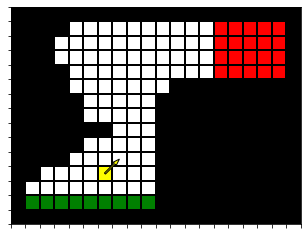

KeyboardInterrupt: 

In [36]:
# POLICY DEMO
num_eps = 500
env = RacetrackEnv()
start_state = env.reset()

for eps in range(num_eps):
    new_episode = generate_episode(env, start_state, policy, show=True)
    print('SUCCESSS!!! '*100)
    start_state = env.reset()

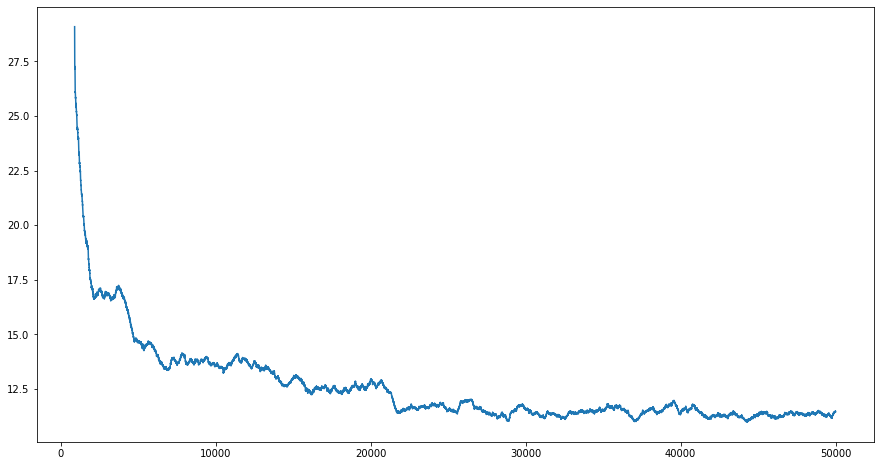

In [35]:
# PLOT TRAJECTORIES LENGTH
lens = []
for t in trajectories:
    lens.append(len(t))
lens_df = pd.DataFrame(lens)
lens_df['mean_len'] = lens_df[0].rolling(900).mean()

plt.figure(figsize=(15,8))
plt.plot(lens_df['mean_len'])

# OFF-POLICY MC

In [2]:
env = RacetrackEnv()

In [3]:
state_action_values = {}
target_policy = {}
beh_policy = {}
sum_weights = {}
default_target_action=1

In [4]:
exploration_eps = 0.6
behaviour_probability_non_opt = exploration_eps/len(env.get_actions())
behaviour_probability_opt = (1-exploration_eps)+exploration_eps/len(env.get_actions())

In [5]:
def find_actions_for_state(state_action_values, state):
    res_d = {}
    visits = 0
    for k in state_action_values:
        if k[0] == state:
            res_d[k] = state_action_values[k]['value']
    return res_d

def find_max_val_action_for_state(state_action_values, state):
    res_d = find_actions_for_state(state_action_values, state)
    if res_d:
        return max(res_d, key=res_d.get)[1]
    else:
        return np.nan
    
def find_state_value(state_action_values, state):
    acts = find_actions_for_state(state_action_values, state)
    
    if acts:
        vals = []
        for k in acts:
            vals.append(acts[k])
        val = np.mean(vals)
    else:
        val = np.nan
        
    return val

def mean_state_vals(state_values):
    mean_vals = {}
    for k in state_values:
        if (k[0],k[1]) in mean_vals:
            mean_vals[(k[0],k[1])] = (mean_vals[(k[0],k[1])] + state_values[k]['value'])/2
        else:
            mean_vals[(k[0],k[1])] = state_values[k]['value']
    return mean_vals

def generate_episode(env, start_state, policy, show = False):
    terminal = False
    cntr = 0
    trajectory = []
    
    stuck=False
    while not terminal:
        if cntr > 0:
            cur_state = new_state
        else:
            cur_state = start_state

        if (cur_state in policy) and not stuck:
            next_action = policy[cur_state]
        else:
            next_action = random.choice(env.get_actions())
            stuck=False
        new_state, reward, terminal = env.step(next_action)
        if new_state == cur_state:
            stuck = True
        trajectory.append((cur_state, next_action, reward, new_state))
        if show:
            env.render()
        cntr+=1
    return trajectory

def update_state_action_values_policy(state_action_values,
                                                sum_weights,
                                                episode,
                                                target_policy, 
                                                beh_policy,
                                                lam = 0.5,
                                                eps = 0.6):
    sum_return = 0
    w_cap = 1
    c_cap = 0
    
    best_decision_counter = 0
    for ep_step in episode[::-1]:
        sum_return = lam*sum_return+ep_step[2]
        
        if (ep_step[0], ep_step[1]) in sum_weights:
            c_cap = sum_weights[(ep_step[0], ep_step[1])] 
        else:
            c_cap = 0
        c_cap = c_cap + w_cap


        if (ep_step[0], ep_step[1]) in state_action_values:
            val = state_action_values[(ep_step[0], ep_step[1])]['value']
        else:
            state_action_values[(ep_step[0], ep_step[1])] = {}
            val = sum_return
        
        if c_cap!=0:
            ro = w_cap/c_cap
        else:
            ro=0
        state_action_values[(ep_step[0], ep_step[1])]['value'] = val +ro*(sum_return-val)


        best_act = find_max_val_action_for_state(state_action_values, ep_step[0])
        target_policy[ep_step[0]] = best_act

        
        if (np.random.uniform() < eps):
            beh_policy[ep_step[0]] = best_act
            best_decision_counter += 1
        else:
            beh_policy[ep_step[0]] = random.choice(env.get_actions())

        ###################################
        
#         if ep_step[1] != best_act:
#             break
        
        ###################################
        
        bi = behaviour_probability_opt if best_act == ep_step[1] else behaviour_probability_non_opt
        if ep_step[0] in target_policy:
            pi = 1 if target_policy[ep_step[0]] == ep_step[1] else 0
        else:
            pi = bi
        w_cap = w_cap*(pi/bi)
    return (state_action_values, state_values, target_policy, beh_policy, best_decision_counter)

In [6]:
env = RacetrackEnv()

state_action_values = {}
state_values = {}

target_policy = {}
beh_policy = {}
sum_weights = {}
default_target_action=1

In [7]:
trajectories = []
beh_trajectories = []
counters = []
for eps in range(5000):
    start_state = env.reset()
    new_episode = generate_episode(env, start_state, beh_policy, show=False)
    
    start_state = env.reset()
    new_t_episode = generate_episode(env, start_state, target_policy, show=False)

    (state_action_values, state_values, target_policy, beh_policy, best_decision_counter) = \
        update_state_action_values_policy(state_action_values,
                                                    state_values,
                                                    new_episode,
                                                    target_policy, 
                                                    beh_policy)

    trajectories.append(new_t_episode)
    beh_trajectories.append(new_episode)
    counters.append(best_decision_counter)
    if eps%500==0:
        print(eps)

0
500
1000
1500
2000
2500
3000
3500
4000
4500


mean_state_vals_d = mean_state_vals(state_values)

list_for_df = []
for k in mean_state_vals_d:
    list_for_df.append([k[0], k[1], mean_state_vals_d[k]])

plt.imshow(pd.DataFrame(list_for_df).pivot(index=0, columns=1, values=2), 
           cmap='hot', interpolation='nearest')
plt.gca().invert_yaxis()

1. Check if the value function getting worse or behaviour policy makes greedy choices less often
2. Check why importance sampling is not required in later chapters



(0.0, 60.0)

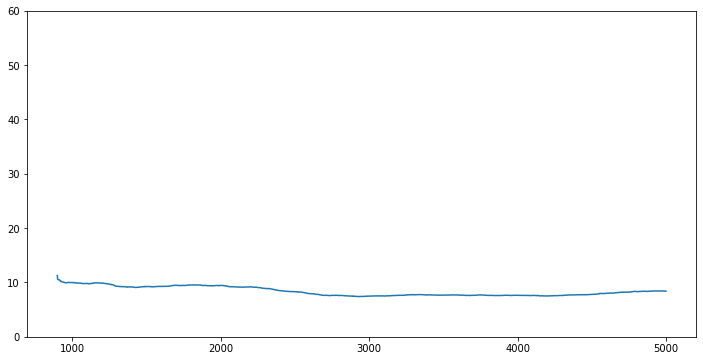

In [8]:
# PLOT TARGET TRAJECTORIES LENGTH
lens = []
for t in trajectories:
    lens.append(len(t))
lens_df = pd.DataFrame(lens)
lens_df['mean_len'] = lens_df[0].rolling(900).mean()

plt.figure(figsize=(12,6))
plt.plot(lens_df['mean_len'])
plt.ylim(0,60)

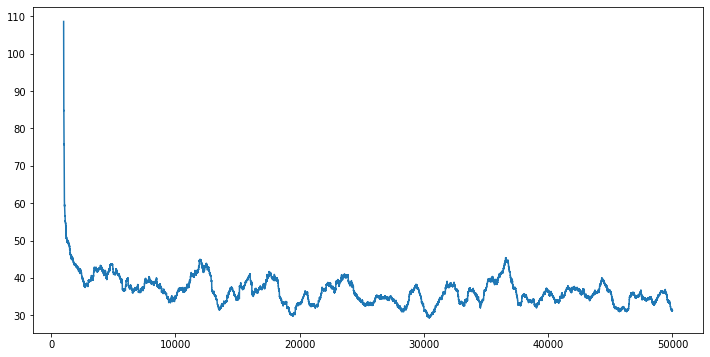

In [58]:
# PLOT BEH TRAJECTORIES LENGTH
lens = []
for t in beh_trajectories:
    lens.append(len(t))
lens_df = pd.DataFrame(lens)
lens_df['mean_len'] = lens_df[0].rolling(1000).mean()

plt.figure(figsize=(12,6))
plt.plot(lens_df['mean_len'])
# plt.ylim(0,60)

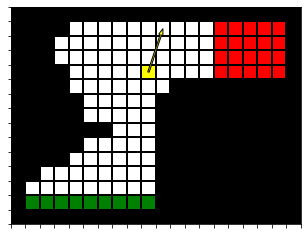

KeyboardInterrupt: 

In [11]:
# POLICY DEMO
num_eps = 500
env = RacetrackEnv()
start_state = env.reset()

for eps in range(num_eps):
    new_episode = generate_episode(env, start_state, target_policy, show=True)
    print('SUCCESSS!!! '*100)
    time.sleep(1)
    start_state = env.reset()

# OFF-Policy Monte-Carlo control on harder map 

In [7]:
env = RacetrackEnv()

state_action_values = {}
state_values = {}

target_policy = {}
beh_policy = {}
sum_weights = {}
default_target_action=1

In [9]:
trajectories = []
beh_trajectories = []
counters = []
for eps in range(50000):
    start_state = env.reset()
    new_episode = generate_episode(env, start_state, beh_policy, show=False)
    
    start_state = env.reset()
    new_t_episode = generate_episode(env, start_state, target_policy, show=False)

    (state_action_values, state_values, target_policy, beh_policy, best_decision_counter) = \
        update_state_action_values_policy(state_action_values,
                                                    state_values,
                                                    new_episode,
                                                    target_policy, 
                                                    beh_policy)

    trajectories.append(new_t_episode)
    beh_trajectories.append(new_episode)
    counters.append(best_decision_counter)
    if eps%50==0:
        print(eps)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750


KeyboardInterrupt: 

In [ ]:
# PLOT BEH TRAJECTORIES LENGTH
lens = []
for t in beh_trajectories:
    lens.append(len(t))
lens_df = pd.DataFrame(lens)
lens_df['mean_len'] = lens_df[0].rolling(1000).mean()

plt.figure(figsize=(12,6))
plt.plot(lens_df['mean_len'])
# plt.ylim(0,60)

(0.0, 60.0)

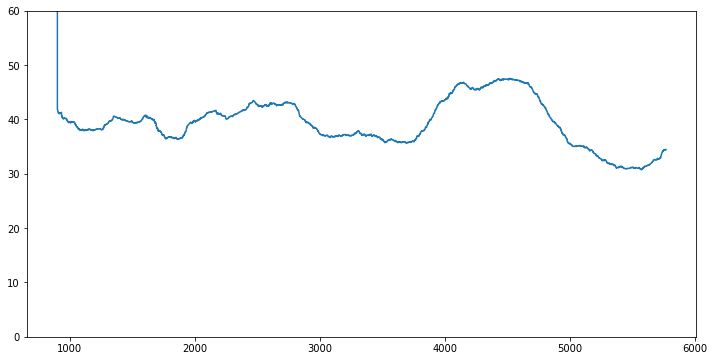

In [10]:
# PLOT TARGET TRAJECTORIES LENGTH
lens = []
for t in trajectories:
    lens.append(len(t))
lens_df = pd.DataFrame(lens)
lens_df['mean_len'] = lens_df[0].rolling(900).mean()

plt.figure(figsize=(12,6))
plt.plot(lens_df['mean_len'])
plt.ylim(0,60)

In [6]:
filehandler = open(b"policy.obj","rb")
target_policy = pickle.load(filehandler)

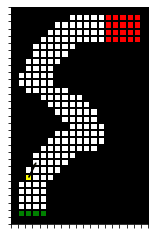

KeyboardInterrupt: 

In [10]:
# POLICY DEMO
num_eps = 500
env = RacetrackEnv()
start_state = env.reset()

for eps in range(num_eps):
    new_episode = generate_episode(env, start_state, target_policy, show=True)
    print('SUCCESSS!!! '*100)
    start_state = env.reset()

# Off-policy TD(0)

In [2]:
def find_actions_for_state(state_action_values, state):
    res_d = {}
    visits = 0
    for k in state_action_values:
        if k[0] == state:
            res_d[k] = state_action_values[k]['value']
    return res_d

def find_max_val_action_for_state(state_action_values, state):
    res_d = find_actions_for_state(state_action_values, state)
    if res_d:
        return max(res_d, key=res_d.get)[1]
    else:
        return None

def run_episode(env, cur_state, cur_action, policy, state_actions_values, show=False):
    terminal = False
    trajectory = []
    while not terminal:
        new_state, reward, terminal = env.step(cur_action)
        next_action = policy[new_state]

        # Now we have: (cur_state, cur_action, reward, new_state, next_action)
        trajectory.append((cur_state, cur_action, reward, new_state, next_action))
        print(len(trajectory))
        cur_state = new_state; cur_action = next_action
        if show:
            env.render()
#             time.sleep(1)
#             clear_output(wait=True)
    
    return trajectory


    
def learn_episode(env, cur_state, cur_action, state_actions_values, policy, show=False):
    
    terminal = False
    trajectory = []
    while not terminal:
        
        new_state, reward, terminal = env.step(cur_action)
        
        ###################################
        best_action = find_max_val_action_for_state(state_actions_values, new_state)
        if not best_action: best_action = random.choice(env.get_actions())
        
        if np.random.uniform() < eps:
            next_action = best_action
#             if not next_action: next_action = random.choice(range(4)) 
        else:
            next_action = random.choice(env.get_actions())
        policy[new_state] = next_action
        ###################################

        # Now we have: (cur_state, cur_action, reward, new_state, next_action)
        trajectory.append((cur_state, cur_action, reward, new_state, next_action))


        if (cur_state, cur_action) in state_actions_values:
            val = state_actions_values[(cur_state, cur_action)]['value']
        else:
            state_actions_values[(cur_state, cur_action)] = {}
            val = 0
            state_actions_values[(cur_state, cur_action)]['value'] = val

        if (new_state, best_action) not in state_actions_values:
            state_actions_values[(new_state, best_action)] = {}
            state_actions_values[(new_state, best_action)]['value'] = 0

        state_actions_values[(cur_state, cur_action)]['value'] = \
            val+alpha*(reward+lam*state_actions_values[(new_state, best_action)]['value'] - val)

        cur_state = new_state; cur_action = next_action
        if show:
            env.render()
#             time.sleep(.99)
#             clear_output(wait=True)
    
    return (trajectory, state_actions_values, policy)

In [3]:
state_actions_values = {}
policy = {}

In [4]:
eps = 0.8
alpha = 0.7
lam = 0.8
batch_size = 10000

env = RacetrackEnv()

trajectories = []
for i in range(10):
    eps +=0.019
    lam +=0.018
    alpha -= 0.03
    for _ in range(batch_size):

        cur_state = env.reset()
        cur_action = random.choice(env.get_actions())

        (trajectory, state_actions_values, policy) = \
            learn_episode(env, cur_state, cur_action, state_actions_values, policy, show=False)
        trajectories.append(trajectory)

        if _%1000==0:
            print(_)
    print(f'\033[91m\033[1m{i} \033[0m', '-'*10)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
0  ----------
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
1  ----------
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
2  ----------
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
3  ----------
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
4  ----------
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
5  ----------
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
6  ----------
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
7  ----------
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
8  ----------
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
9  ----------


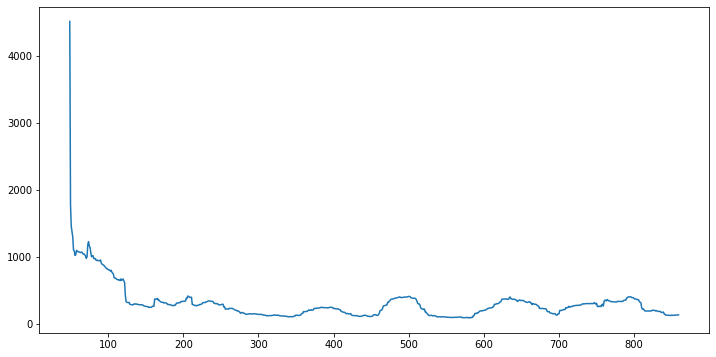

In [14]:
# PLOT TRAJECTORIES LENGTH
lens = []
for t in trajectories:#[:1500]:
    lens.append(len(t))
lens_df = pd.DataFrame(lens)
lens_df['mean_len'] = lens_df[0].rolling(50).mean()

plt.figure(figsize=(12,6))
plt.plot(lens_df['mean_len'])
# plt.ylim(0,900)

(0.0, 900.0)

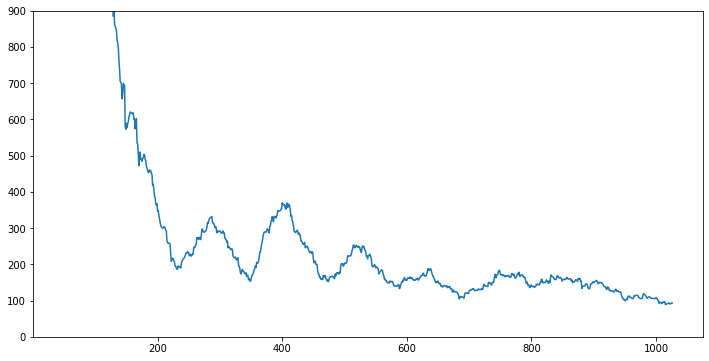

In [18]:
# PLOT TRAJECTORIES LENGTH

# eps = 0.8
# alpha = 0.5
# lam = 0.95

lens = []
for t in trajectories:#[:1500]:
    lens.append(len(t))
lens_df = pd.DataFrame(lens)
lens_df['mean_len'] = lens_df[0].rolling(50).mean()

plt.figure(figsize=(12,6))
plt.plot(lens_df['mean_len'])
plt.ylim(0,900)

(0.0, 900.0)

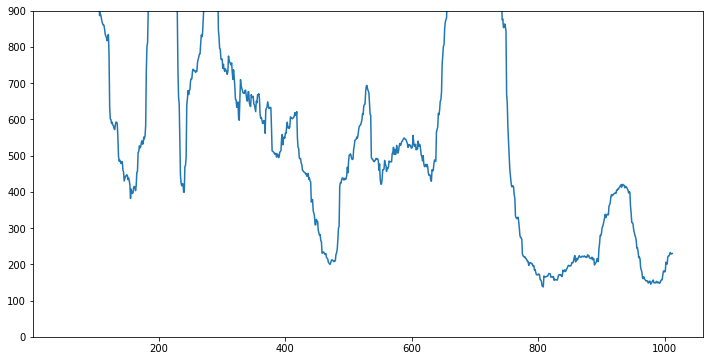

In [21]:
# PLOT TRAJECTORIES LENGTH

# eps = 0.8
# alpha = 0.5
# lam = 0.85

lens = []
for t in trajectories:#[:1500]:
    lens.append(len(t))
lens_df = pd.DataFrame(lens)
lens_df['mean_len'] = lens_df[0].rolling(50).mean()

plt.figure(figsize=(12,6))
plt.plot(lens_df['mean_len'])
plt.ylim(0,900)

(0.0, 900.0)

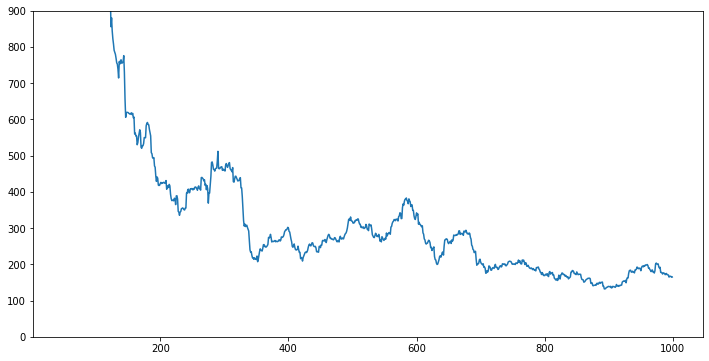

In [24]:
# PLOT TRAJECTORIES LENGTH

# eps = 0.7
# alpha = 0.5
# lam = 0.95

lens = []
for t in trajectories:#[:1500]:
    lens.append(len(t))
lens_df = pd.DataFrame(lens)
lens_df['mean_len'] = lens_df[0].rolling(50).mean()

plt.figure(figsize=(12,6))
plt.plot(lens_df['mean_len'])
plt.ylim(0,900)

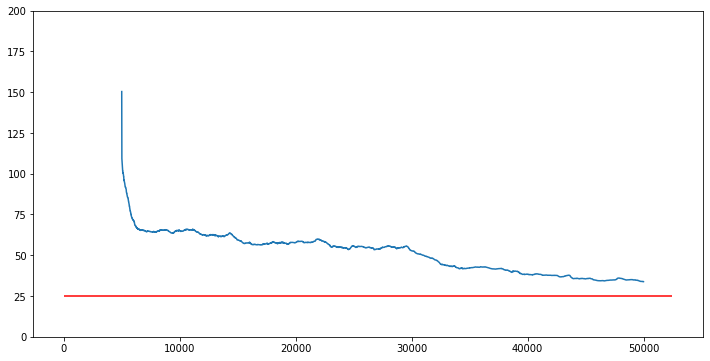

In [28]:
# PLOT TRAJECTORIES LENGTH


lens = []
for t in trajectories:#[:1500]:
    lens.append(len(t))
lens_df = pd.DataFrame(lens)
lens_df['mean_len'] = lens_df[0].rolling(5000).mean()

plt.figure(figsize=(12,6))
plt.plot(lens_df['mean_len'])
plt.ylim(0,200)
plt.hlines(25,0,len(lens_df)+len(lens_df)*.05, color='red')

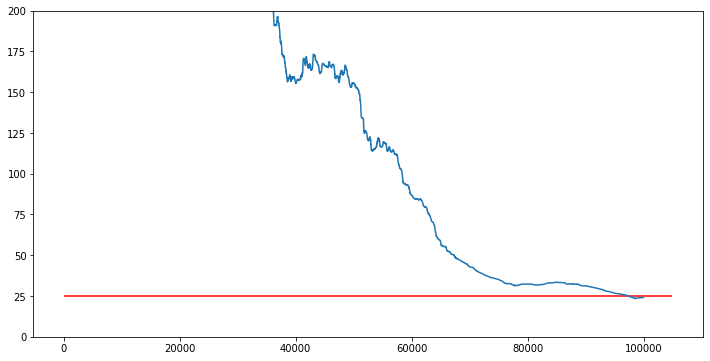

In [8]:
# PLOT TRAJECTORIES LENGTH


lens = []
for t in trajectories:#[:1500]:
    lens.append(len(t))
lens_df = pd.DataFrame(lens)
lens_df['mean_len'] = lens_df[0].rolling(10000).mean()

plt.figure(figsize=(12,6))
plt.plot(lens_df['mean_len'])
plt.ylim(0,200)
plt.hlines(25,0,len(lens_df)+len(lens_df)*.05, color='red')

In [18]:
# POLICY DEMO
env = RacetrackEnv()

cur_state = env.reset()
cur_action = env.get_actions()[0]


for episode in range(10):
    new_episode = run_episode(env, cur_state, cur_action, policy, state_action_values, show=True)
    print('SUCCESSS!!! '*100)
    cur_state = env.reset()
    cur_action = 1
    

NameError: name 'state_actions_values' is not defined

# Dyna

In [2]:
def find_max_val_action_for_state(state_action_values, state):
    res_d = {}
    for k in state_action_values:
        if k[0] == state:
            res_d[k] = state_action_values[k]['value']
    if res_d:
        return max(res_d, key=res_d.get)[1]
    else:
        return random.choice(env.get_actions())


def choose_greedy_action(best_action, eps):
    if np.random.uniform() < eps:
        next_action = best_action
    else:
        next_action = random.choice(env.get_actions())
    
    return next_action

def update_state_action_values(state_action_values, 
                               cur_state, 
                               cur_action, 
                               reward, 
                               next_state, 
                               best_action):
    
    local_cp = state_action_values.copy()
    
    
    if (cur_state, cur_action) in local_cp:
        val = local_cp[(cur_state, cur_action)]['value']
    else:
        local_cp[(cur_state, cur_action)] = {}
        val = 0
        local_cp[(cur_state, cur_action)]['value'] = val

    if (next_state, best_action) not in local_cp:
        local_cp[(next_state, best_action)] = {}
        local_cp[(next_state, best_action)]['value'] = 0

    local_cp[(cur_state, cur_action)]['value'] = \
        val+alpha*(reward+lam*local_cp[(next_state, best_action)]['value'] - val)
    
    
    return local_cp

def optimise_world(world_map, state_action_values):
    
    local_state_action_values = state_action_values.copy()
    local_world_map = world_map.copy()
    
    (cur_state, cur_action) = random.choice(list(local_world_map.keys()))
    (next_state, reward) = local_world_map[(cur_state, cur_action)]
    best_action = find_max_val_action_for_state(local_state_action_values, next_state)
    
    return update_state_action_values(local_state_action_values, 
                                      cur_state, 
                                      cur_action, 
                                      reward, 
                                      next_state, 
                                      best_action)

def run_episode(env, cur_state, cur_action, policy, state_action_values, show=False):
    done = False
    trajectory = []
    while not done:
        next_state, reward, done = env.step(cur_action)
        if next_state in policy:
            next_action = policy[next_state]
        else:
            best_action = find_max_val_action_for_state(state_action_values, next_state)
            next_action =  choose_greedy_action(best_action, eps)
            
#             next_action = select_greedy_action(next_state, state_action_values, eps)

        # Now we have: (cur_state, cur_action, reward, new_state, next_action)
        trajectory.append((cur_state, cur_action, reward, next_state, next_action))
        print(len(trajectory))
        cur_state = next_state; cur_action = next_action
        if show:
            env.render()
#             time.sleep(.2)
#             clear_output(wait=True)
    
    return trajectory

def learn_episode(cur_state, 
                  cur_action, 
                  state_action_values, 
                  policy, 
                  world_map,
                  ep_cntr,
                  show=False):
    
    local_state_action_values = state_action_values.copy()
    local_policy = policy.copy()
    local_world_map = world_map.copy()
    ep_sum_reward = 0
    trajectory=[]
    done = False
    while not done:
        
        next_state, reward, done = env.step(cur_action); ep_sum_reward+=reward
        local_world_map[(cur_state, cur_action)] = (next_state, reward)

        best_action = find_max_val_action_for_state(local_state_action_values, next_state)
        next_action =  choose_greedy_action(best_action, eps)
        
        local_policy[next_state] = best_action
        trajectory.append((cur_state, cur_action, reward, next_state))
        
        local_state_action_values = \
            update_state_action_values(local_state_action_values, cur_state, cur_action, reward, 
                                       next_state, best_action)
        
        if ep_cntr > 0:
            for model_step in range(40): #2*len(local_world_map)
                local_state_action_values = optimise_world(local_world_map, local_state_action_values)
        
        cur_state = next_state; cur_action = next_action
        
        if show:
            env.render()
            clear_output(wait=True)
            time.sleep(.3)
    
    
    return (trajectory, local_state_action_values, local_policy, ep_sum_reward, local_world_map)



In [3]:
eps = 0.9
alpha = 0.81
lam = 0.96

world_map = {}
state_action_values = {}
policy = {}

# env = gym.make("Taxi-v3").env
env = RacetrackEnv()
# cur_state = env.reset()
# cur_action =  env.action_space.sample()  

episodes = 1000
ep_sums = []
trajectories = []
for ep_num in range(episodes):
    cur_state = env.reset()
    cur_action = random.choice(env.get_actions())
    (trajectory, state_action_values, policy, ep_sum_reward, world_map) = \
        learn_episode(cur_state, 
                      cur_action,
                      state_action_values, 
                      policy,
                      world_map,
                      ep_num,
                      show=False)
    trajectories.append(trajectory)
    ep_sums.append(ep_sum_reward)
    
    if ep_num%1==0:
        print(f'{ep_num}:', ep_sum_reward, len(trajectory))
        print('#'*30)
    

0: -6401 2351
##############################
1: -19672 10142
##############################
2: -120 90
##############################
3: -66338 36408
##############################
4: -3401 1901
##############################
5: -20635 11755
##############################
6: -533 253
##############################
7: -27355 15565
##############################
8: -14503 8073
##############################
9: -78512 46192
##############################
10: -12939 7789
##############################
11: -1019 599
##############################
12: -173 93
##############################
13: -118 68
##############################
14: -384 224
##############################
15: -75 55
##############################
16: -35 35
##############################
17: -142 92
##############################
18: -132 82
##############################
19: -1890 1070
##############################
20: -697 437
##############################
21: -136160 84200
##############################
22: -700 380


186: -4360 2740
##############################
187: -380 240
##############################
188: -16 26
##############################
189: -634 414
##############################
190: -343 213
##############################
191: -1401 831
##############################
192: -446 246
##############################
193: -1372 902
##############################
194: -29 29
##############################
195: -31 31
##############################
196: -1963 1283
##############################
197: -66 66
##############################
198: -736 466
##############################
199: -72 52
##############################
200: -19 29
##############################
201: -153 103
##############################
202: -131 71
##############################
203: -300 180
##############################
204: -425 245
##############################
205: -501 301
##############################
206: -250 150
##############################
207: -199 119
##############################
208: -246 166
###

373: -96 56
##############################
374: -222 142
##############################
375: -37 37
##############################
376: -56 36
##############################
377: -63 53
##############################
378: -1575 945
##############################
379: -844 504
##############################
380: -450 250
##############################
381: -241 151
##############################
382: -2680 1600
##############################
383: -802 572
##############################
384: -228 168
##############################
385: -709 489
##############################
386: -583 403
##############################
387: -45 45
##############################
388: -322 192
##############################
389: -59 49
##############################
390: -164 114
##############################
391: -910 490
##############################
392: -1044 624
##############################
393: -9 19
##############################
394: -572 342
##############################
395: -66 46
#########

559: -42 42
##############################
560: -113 63
##############################
561: -185 105
##############################
562: -94 64
##############################
563: -20 20
##############################
564: -35 25
##############################
565: -20 20
##############################
566: -27 27
##############################
567: -86 66
##############################
568: -187 117
##############################
569: -21 21
##############################
570: -11 21
##############################
571: -76 56
##############################
572: -6 16
##############################
573: -68 48
##############################
574: -36 26
##############################
575: -84 54
##############################
576: -121 81
##############################
577: -46 36
##############################
578: -80 60
##############################
579: -35 35
##############################
580: -118 78
##############################
581: -256 146
##############################
582

747: -188 138
##############################
748: -28 28
##############################
749: -270 190
##############################
750: -34 34
##############################
751: -21 21
##############################
752: -30 30
##############################
753: -251 151
##############################
754: -303 183
##############################
755: -139 89
##############################
756: -177 117
##############################
757: -22 22
##############################
758: -94 64
##############################
759: -133 83
##############################
760: -278 168
##############################
761: -41 41
##############################
762: -60 60
##############################
763: -111 81
##############################
764: -33 33
##############################
765: -103 73
##############################
766: -29 29
##############################
767: -313 183
##############################
768: -58 38
##############################
769: -150 100
######################

935: -124 84
##############################
936: -43 33
##############################
937: -20 20
##############################
938: -18 18
##############################
939: -96 66
##############################
940: -261 151
##############################
941: -9 19
##############################
942: -259 159
##############################
943: -35 25
##############################
944: -10 20
##############################
945: -93 63
##############################
946: -181 121
##############################
947: -190 120
##############################
948: -178 138
##############################
949: -21 31
##############################
950: -51 41
##############################
951: -50 40
##############################
952: -14 24
##############################
953: -110 60
##############################
954: -105 65
##############################
955: -99 69
##############################
956: -204 124
##############################
957: -15 25
############################

(0.0, 500.0)

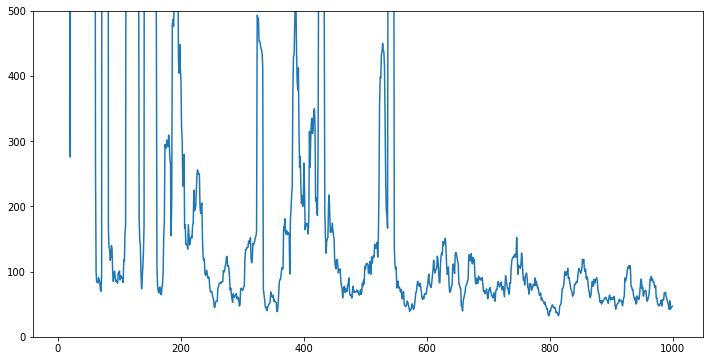

In [5]:
# PLOT TRAJECTORIES LENGTH


lens = []
for t in trajectories:#[:1500]:
    lens.append(len(t))
lens_df = pd.DataFrame(lens)
lens_df['mean_len'] = lens_df[0].rolling(10).mean()

plt.figure(figsize=(12,6))
plt.plot(lens_df['mean_len'])
plt.ylim(0,500)

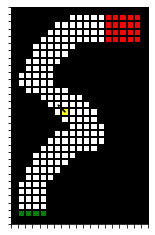

KeyboardInterrupt: 

In [8]:
# POLICY DEMO
num_eps = 500
env = RacetrackEnv()
cur_state = env.reset()
cur_action = random.choice(env.get_actions())

for eps in range(num_eps):
    new_episode = run_episode(env, cur_state, cur_action, policy, state_action_values, show=True)
    print('SUCCESSS!!! '*100)
    start_state = env.reset()

# Prioritised sweeping

In [12]:
def find_max_val_action_for_state(state_action_values, state):
    res_d = {}
    for k in state_action_values:
        if k[0] == state:
            res_d[k] = state_action_values[k]['value']
    if res_d:
        return max(res_d, key=res_d.get)[1]
    else:
        return random.choice(env.get_actions())


def choose_greedy_action(best_action, eps):
    if np.random.uniform() < eps:
        next_action = best_action
    else:
        next_action = random.choice(env.get_actions())

    return next_action


def update_state_action_values(state_action_values, 
                               cur_state, 
                               cur_action, 
                               reward, 
                               next_state, 
                               best_action,
                               verbose):

    local_cp = state_action_values.copy()


    if (cur_state, cur_action) in local_cp:
        val = local_cp[(cur_state, cur_action)]['value']
    else:
        local_cp[(cur_state, cur_action)] = {}
        val = 0
        local_cp[(cur_state, cur_action)]['value'] = val

    if (next_state, best_action) not in local_cp:
        local_cp[(next_state, best_action)] = {}
        local_cp[(next_state, best_action)]['value'] = 0
    if verbose:
        print('%'*30)
        print('UPDATING Q_VALUE')
        print('current val:', val)
        print('TD error', reward+lam*local_cp[(next_state, best_action)]['value'] - val)
        print('%'*30)
    local_cp[(cur_state, cur_action)]['value'] = \
        val+alpha*(reward+lam*local_cp[(next_state, best_action)]['value'] - val)


    return local_cp


def find_all_predecessors(world_map, state):
    res_lst = []
    for k in world_map:
        if world_map[k][0] == state:
            res_lst.append(k)
    return res_lst


def calc_val_change(cur_state, 
                    cur_action, 
                    reward, 
                    next_state, 
                    best_action, 
                    state_action_values,
                    verbose):
    local_cp = state_action_values.copy()


    if (cur_state, cur_action) in local_cp:
        val = local_cp[(cur_state, cur_action)]['value']
#         print(cur_state, cur_action, val)
    else:
        local_cp[(cur_state, cur_action)] = {}
        val = 0
        local_cp[(cur_state, cur_action)]['value'] = val

    if (next_state, best_action) not in local_cp:
        local_cp[(next_state, best_action)] = {}
        local_cp[(next_state, best_action)]['value'] = 0

    if verbose:
        print('^'*30)
        print('CURRENT:', (cur_state, cur_action), val)
        print('reward:', reward)
        print('lam:', lam)
        print('Value with best act:', local_cp[(next_state, best_action)]['value'])
        print('Res dif:', abs(reward+lam*local_cp[(next_state, best_action)]['value'] - val))
        print('^'*30)

    return abs(reward+lam*local_cp[(next_state, best_action)]['value'] - val)

# [cur_state, action, val_change]


def optimise_world(world_map, state_action_values, PQueue, change_thresh, verbose):

    local_state_action_values = state_action_values.copy()
    local_world_map = world_map.copy()

    priority_move = list(np.array(PQueue, dtype=object)[np.array(PQueue, dtype=object)[:, 2].argsort()[::-1]][0])

    if verbose: 
        print('-'*30)
        print('PQueue:', PQueue)
        print('Best move:', priority_move)

    PQueue.pop(PQueue.index(priority_move))

    (cur_state, cur_action) = (priority_move[0], priority_move[1]) #random.choice(list(local_world_map.keys())) #
    (next_state, reward) = local_world_map[(cur_state, cur_action)]
    best_action = find_max_val_action_for_state(local_state_action_values, next_state)
    if verbose: print('BEST ACT:', best_action)
    if verbose: print(f'VAL BEFORE {(cur_state, cur_action)}', local_state_action_values[(cur_state, cur_action)])
    local_state_action_values = update_state_action_values(local_state_action_values, 
                                                           cur_state, 
                                                           cur_action, 
                                                           reward, 
                                                           next_state, 
                                                           best_action, 
                                                           verbose=False)
    if verbose: print(f'VAL AFTER {(cur_state, cur_action)}', local_state_action_values[(cur_state, cur_action)])

    all_preds = find_all_predecessors(local_world_map, cur_state)
    if verbose: print('STATE', cur_state, 'ALL PREDS', all_preds)
    for pred in all_preds:
        (pred_cur_state, pred_action) = (pred[0], pred[1])
        (pred_next_state, pred_rew) = local_world_map[pred]
        pred_best_action = find_max_val_action_for_state(local_state_action_values, pred_next_state)
        pred_val_change = calc_val_change(pred_cur_state, 
                                          pred_action, 
                                          pred_rew, 
                                          pred_next_state, 
                                          pred_best_action,
                                          local_state_action_values,
                                          verbose=False)
        if verbose: print(pred, pred_val_change)
        if pred_val_change > change_thresh:
            tmp_q = [k for k in PQueue if k[0] == pred_cur_state and k[1] == pred_action]
            if verbose: print('INNER TMP_Q:', tmp_q)
            if not tmp_q:
                PQueue.append([pred_cur_state, pred_action, pred_val_change])
    return (local_state_action_values, PQueue)


def run_episode(env, cur_state, cur_action, policy, state_action_values, show=False):
    done = False
    trajectory = []
    while not done:
        next_state, reward, done = env.step(cur_action); next_state = tuple(next_state)
        if next_state in policy:
            next_action = policy[next_state]
        else:
            best_action = find_max_val_action_for_state(state_action_values, next_state)
            next_action =  choose_greedy_action(best_action, eps)

#             next_action = select_greedy_action(next_state, state_action_values, eps)

        # Now we have: (cur_state, cur_action, reward, new_state, next_action)
        trajectory.append((cur_state, cur_action, reward, next_state, next_action))
        print(len(trajectory))
        cur_state = next_state; cur_action = next_action
        if show:
            env.render()
            time.sleep(.05)
#             clear_output(wait=True)

    return trajectory


def learn_episode(env, 
                  cur_state, 
                  cur_action, 
                  state_action_values, 
                  policy,
                  world_map,
                  ep_num,
                  PQueue,
                  change_thresh=1,
                  verbose=True,
                  show=False):
    local_state_action_values = state_action_values.copy()
    local_policy = policy.copy()
    local_world_map = world_map.copy()
    ep_sum_reward = 0
    trajectory=[]
    done = False
    while not done:

        next_state, reward, done = env.step(cur_action); ep_sum_reward+=reward
        next_state = tuple(next_state)
        local_world_map[(cur_state, cur_action)] = (next_state, reward)

        best_action = find_max_val_action_for_state(local_state_action_values, next_state)
        next_action =  choose_greedy_action(best_action, eps)
        val_change = calc_val_change(cur_state, cur_action, reward, next_state, 
                                     best_action, state_action_values, verbose=False)
        if val_change > change_thresh:
            tmp_q = [k for k in PQueue if k[0] == cur_state and k[1] == cur_action]
            if not tmp_q:
                if verbose: print('ADDED IN OUTTER:', [cur_state, cur_action, val_change])
                PQueue.append([cur_state, cur_action, val_change])

        local_policy[next_state] = best_action
        trajectory.append((cur_state, cur_action, reward, next_state))

        local_state_action_values = \
            update_state_action_values(local_state_action_values, cur_state, cur_action, reward, 
                                       next_state, best_action, verbose=False)

        if (ep_num > 0) :
            st_num = 200 #round(2*np.sqrt(len(local_world_map)))
            for model_step in range(st_num): #2*len(local_world_map)
                if PQueue:
                    if verbose: print('PQueue len:', len(PQueue))
                    (local_state_action_values, PQueue) = optimise_world(local_world_map, 
                                                                         local_state_action_values, 
                                                                         PQueue, 
                                                                         change_thresh,
                                                                         verbose)

        cur_state = next_state; cur_action = next_action

        if show:
            env.render()
            clear_output(wait=True)
            time.sleep(.3)

    return (trajectory, 
            local_state_action_values, 
            local_policy, 
            ep_sum_reward, 
            local_world_map, 
            PQueue)

In [6]:
env = RacetrackEnv()

In [5]:
eps = 0.6
alpha = 0.81
lam = 0.96

world_map = {}
state_action_values = {}
policy = {}
PQueue = []

episodes = 1500
ep_sums = []
trajectories = []

for ep_num in range(episodes):
    cur_state = tuple(env.reset())
    cur_action =  random.choice(env.get_actions())
    verbose = True if (ep_num > 0) else False
#     print(f'EP NUM {ep_num} START')
    (trajectory, state_action_values, policy, ep_sum_reward, world_map, PQueue) = \
        learn_episode(env,
                      cur_state,
                      cur_action,
                      state_action_values,
                      policy,
                      world_map,
                      ep_num,
                      PQueue,
                      verbose=False,
                      show=False)
    trajectories.append(trajectory)
    ep_sums.append(ep_sum_reward)

    if ep_num%25==0:
        print(f'EP NUM {ep_num} END:', ep_sum_reward, len(trajectory))
        print('#'*30)

EP NUM 0 END: -140390 52710
##############################
EP NUM 25 END: -3799 1579
##############################
EP NUM 50 END: -799 359
##############################
EP NUM 75 END: -3981 1531
##############################
EP NUM 100 END: -831 341
##############################
EP NUM 125 END: -825 365
##############################
EP NUM 150 END: -43 23
##############################
EP NUM 175 END: -1174 474
##############################
EP NUM 200 END: -780 300
##############################
EP NUM 225 END: -379 139
##############################
EP NUM 250 END: -914 394
##############################
EP NUM 275 END: -780 330
##############################
EP NUM 300 END: -289 119
##############################
EP NUM 325 END: -1504 634
##############################
EP NUM 350 END: -2582 1062
##############################
EP NUM 375 END: -544 234
##############################
EP NUM 400 END: -367 167
##############################
EP NUM 425 END: -1099 449
################

KeyboardInterrupt: 

In [10]:
filehandler = open(b"prioritised_sweeping_policy.obj","wb")
target_policy = pickle.dump(policy, filehandler)

In [3]:
filehandler = open(b"prioritised_sweeping_policy.obj","rb")
target_policy = pickle.load(filehandler)

In [10]:
state_action_values = {}

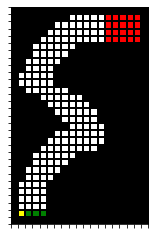

2


In [ ]:
# POLICY DEMO
num_eps = 500
env = RacetrackEnv()
cur_state = env.reset()
cur_action = random.choice(env.get_actions())

for eps in range(num_eps):
    new_episode = run_episode(env, cur_state, cur_action, target_policy, state_action_values, show=True)
    print('SUCCESSS!!! '*100)
    start_state = env.reset()